In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

import time

# Data

- 데이터 출처
  - https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data

In [3]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
data = data.drop(['id'], axis=1)
data = data[data['gender'] != 'Other']
data.head()

df = data.copy()
df.loc[:, ["hypertension", "heart_disease", "stroke"]] = data.loc[:, ["hypertension", "heart_disease", "stroke"]].applymap(lambda x: "Yes" if x == 1 else "No")
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,No,Yes,Yes,Private,Urban,228.69,36.6,formerly smoked,Yes
1,Female,61.0,No,No,Yes,Self-employed,Rural,202.21,NaN,never smoked,Yes
2,Male,80.0,No,Yes,Yes,Private,Rural,105.92,32.5,never smoked,Yes
3,Female,49.0,No,No,Yes,Private,Urban,171.23,34.4,smokes,Yes
4,Female,79.0,Yes,No,Yes,Self-employed,Rural,174.12,24.0,never smoked,Yes


In [4]:
X = df.drop(["stroke"], axis=1)
y = LabelEncoder().fit_transform(df['stroke'])

X_num = X.select_dtypes(include = 'number')
X_cat = X.select_dtypes(exclude = 'number')

X[X_num.columns] = SimpleImputer(strategy="mean").fit_transform(X_num)
X[X_cat.columns] = SimpleImputer(strategy="most_frequent").fit_transform(X_cat)

In [5]:
scaler = StandardScaler()

onehot = OneHotEncoder(drop = 'first', handle_unknown='ignore', sparse_output=False)

ct = ColumnTransformer([('scaler', scaler, X_num.columns),
                        ('onehot', onehot, X_cat.columns)], 
                       remainder='passthrough', n_jobs=-1)

ct

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('scaler', StandardScaler(),
                                 Index(['age', 'avg_glucose_level', 'bmi'], dtype='object')),
                                ('onehot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smoking_status'],
      dtype='object'))])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
ct.fit(X_train)

ColumnTransformer(n_jobs=-1, remainder='passthrough',
                  transformers=[('scaler', StandardScaler(),
                                 Index(['Age', 'eGFR', 'SBP', 'DBP', 'HbA1c', 'Creatinine', 'Hemoglobin'], dtype='object')),
                                ('onehot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 Index(['Sex', 'Hypertension', 'Dyslipidemia', 'Heart', 'Stroke',
       'Diabetic medicine', 'Insulin', 'Arb Acei', 'Diuretics', 'Statin'],
      dtype='object'))])

- 조기 중단(`early_stopooing_rounds`)
  - 검증 데이터셋의 손실 값이 증가하기 시작할 때(손실을 최소화하는 경우) 훈련을 중단하는 기법.
  - 따라서 모델을 훈련시키기 위해서는 두 개의 별도 데이터셋 필요
    - 모델 피팅을 위한 훈련 데이터
    - 손실 모니터링과 조기 중단을 위한 검증 데이터

- Xgboost 알고리즘에서는 `early_stoping_rounds` 매개변수가 손실 값이 다음으로 감소할 때까지 기다릴 허용 범위를 제어.
- 이 매개변수가 필요한 이유는 각 반복마다 손실 값이 무작위로 감소하기 때문입니다. 검증 손실은 일정 범위 내에서 변동할 수 있으며, 몇 번의 반복 후에 감소할 수 있습니다.
    - 일반적으로 조기 중단을 위해 50번의 반복을 사용하며, 보통 1000개의 트리와 함께 사용.
    - 전체 반복 횟수의 10%를 조기 중단에 사용하는 것이 합리적이라는 몇 가지 경험적인 법칙이 있습니다.

https://mljar.com/blog/xgboost-early-stopping/

In [7]:
# learning_rate, n_estimators, max_depth, min_child_weight, gamma, subsample, colsample_bytree, scale_pos_weight, early_stopping_rounds

predictr = XGBClassifier(learning_rate = 0.1,
                         n_estimators = 1000, 
                         max_depth = 3, 
                         min_child_weight = 3, 
                         gamma = 5, 
                         subsample = 0.5, 
                         colsample_bytree = 0.5, 
                         random_state = 42, 
                         scale_pos_weight = 1, 
                         eval_metric='logloss', 
                         early_stopping_rounds = 50)

In [8]:
start_time = time.time()

predictr.fit(ct.fit_transform(X_train), y_train, eval_set = [(ct.fit_transform(X_train), y_train), (ct.transform(X_test), y_test)], verbose=2)

end_time = time.time()
print("코드 실행 시간: {:.1f} 초".format(end_time - start_time))

[0]	validation_0-logloss:0.61542	validation_1-logloss:0.61582
[2]	validation_0-logloss:0.49849	validation_1-logloss:0.49832
[4]	validation_0-logloss:0.41477	validation_1-logloss:0.41376
[6]	validation_0-logloss:0.35415	validation_1-logloss:0.35375
[8]	validation_0-logloss:0.30894	validation_1-logloss:0.30850
[10]	validation_0-logloss:0.27531	validation_1-logloss:0.27517
[12]	validation_0-logloss:0.24932	validation_1-logloss:0.24899
[14]	validation_0-logloss:0.22942	validation_1-logloss:0.22914
[16]	validation_0-logloss:0.21511	validation_1-logloss:0.21476
[18]	validation_0-logloss:0.20194	validation_1-logloss:0.20147
[20]	validation_0-logloss:0.19201	validation_1-logloss:0.19223
[22]	validation_0-logloss:0.18444	validation_1-logloss:0.18521
[24]	validation_0-logloss:0.17758	validation_1-logloss:0.17886
[26]	validation_0-logloss:0.17243	validation_1-logloss:0.17448
[28]	validation_0-logloss:0.16791	validation_1-logloss:0.17113
[30]	validation_0-logloss:0.16564	validation_1-logloss:0.169

In [9]:
print('반복 횟수 : %d, 평가 지표 : %s' % (predictr.best_iteration, predictr.eval_metric))

반복 횟수 : 81, 평가 지표 : logloss


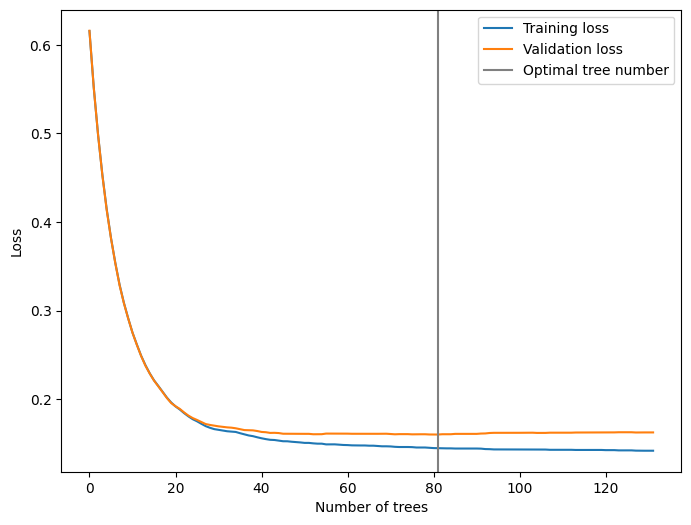

In [10]:
from matplotlib import pyplot as plt

results = predictr.evals_result()

plt.figure(figsize=(8,6))
plt.plot(results["validation_0"]["logloss"], label="Training loss")
plt.plot(results["validation_1"]["logloss"], label="Validation loss")
plt.axvline(predictr.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend();

### 튜닝 + early stopping

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline

In [11]:
predictr = XGBClassifier(n_estimators = 1000,
                         random_state = 42, 
                         scale_pos_weight = 1,
                         eval_metric='logloss', 
                         early_stopping_rounds = 50)

pipe = Pipeline([('ct', ct), ("XGBoost", predictr)]);pipe

Pipeline(steps=[('ct',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('scaler', StandardScaler(),
                                                  Index(['age', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'Residence_type', 'smok...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=1000,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [12]:
param_dist = {
    'XGBoost__learning_rate': scipy.stats.uniform(0.01, 1.99),
    'XGBoost__n_estimators': scipy.stats.randint(50, 150),
    'XGBoost__max_depth': scipy.stats.randint(4, 8),
    'XGBoost__colsample_bytree': scipy.stats.uniform(0.4, 0.4),
    'XGBoost__gamma' : scipy.stats.randint(3, 6),
    'XGBoost__min_child_weight' : scipy.stats.randint(8, 16),
    'XGBoost__subsample' : scipy.stats.uniform(0.4, 0.4),
}

In [13]:
start_time = time.time()

predictr_rs = RandomizedSearchCV(pipe, 
                                 param_dist,
                                 n_iter = 10, # default
                                 cv=5, 
                                 scoring='accuracy',
                                 random_state=42, 
                                 refit = True,
                                 n_jobs = -1)

fit_params = {"XGBoost__eval_set" : [(ct.fit_transform(X_train), y_train)]}
verbose = {"XGBoost__verbose": False}

predictr_rs.fit(X_train, y_train, **fit_params, **verbose)
pipe.set_params(**{key: round(value, 2) for key, value in predictr_rs.best_params_.items()}).fit(X_train, y_train, **fit_params, **verbose)

end_time = time.time()
print("코드 실행 시간: {:.1f} 초".format(end_time - start_time))

코드 실행 시간: 6.1 초


In [14]:
start_time = time.time()

scores = cross_validate(estimator = pipe,
                        X=X_train,
                        y=y_train,
                        fit_params = fit_params,
                        scoring = ['accuracy', 'roc_auc'],
                        cv=5,
                        n_jobs = -1)

accuracy_score_rs = np.mean(scores['test_accuracy']).round(4);accuracy_score
roc_auc_score_rs = np.mean(scores['test_roc_auc']).round(4);roc_auc_score

end_time = time.time()
print("코드 실행 시간: {:.1f} 초".format(end_time - start_time))

[0]	validation_0-logloss:0.44247
코드 실행 시간: 0.9 초


In [15]:
print("Best Parameters: ", predictr_rs.best_params_)
print("Best Parameters after round: ", pipe.named_steps["XGBoost"].set_params)
print("Best Score in CV: ", predictr_rs.best_score_)
print("mean Score after round:", accuracy_score_rs)
print("Best test Score: ", pipe.named_steps["XGBoost"].score(ct.transform(X_test), y_test))

Best Parameters:  {'XGBoost__colsample_bytree': 0.5498160475389451, 'XGBoost__gamma': 3, 'XGBoost__learning_rate': 0.37503523183366594, 'XGBoost__max_depth': 7, 'XGBoost__min_child_weight': 12, 'XGBoost__n_estimators': 70, 'XGBoost__subsample': 0.46240745617697465}
Best Parameters after round:  <bound method XGBModel.set_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.55, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=3, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.38, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=12, missing=nan,
              monotone_constraints=None, n_estimators=70, n_jobs=None,